In [21]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline


In [45]:
# The code was removed by DSX for sharing.

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27,4,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19,3,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29,2,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50,9,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77,4,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


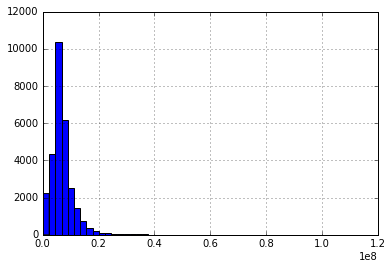

In [46]:
df_train['price_doc'].hist(bins=50)

In [47]:
y_train_all = df_train['price_doc'].values
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = df_all.join(df_macro, on='timestamp', rsuffix='_macro')
print(df_all.shape)

# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

(36557, 390)


In [48]:
factorize = lambda t: pd.factorize(t[1])[0]

df_obj = df_all.select_dtypes(include=['object'])

X_all = np.c_[
    df_all.select_dtypes(exclude=['object']).values,
    np.array(list(map(factorize, df_obj.iteritems()))).T
]
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

(36557, 394)


In [49]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [50]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

X_train_all = X_all[:num_train]
X_test_all = X_all[num_train:]

df_columns = df_values.columns

(36557, 394)


In [51]:
from sklearn.model_selection import train_test_split

bins     = np.linspace(0, 50, 25)
y_binned = np.digitize(y_train_all, bins)
X_train, X_test, y_train, y_test = train_test_split(X_train_all, y_train_all, stratify=y_binned,test_size=0.2)

In [57]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(X_train_all, y_train_all, feature_names=df_columns)
dtest = xgb.DMatrix(X_test_all, feature_names=df_columns)

[0]	train-rmse:8.12439e+06	test-rmse:8.12979e+06
[20]	train-rmse:3.9224e+06	test-rmse:4.08207e+06
[40]	train-rmse:2.73101e+06	test-rmse:3.06002e+06
[60]	train-rmse:2.38843e+06	test-rmse:2.83217e+06
[80]	train-rmse:2.25425e+06	test-rmse:2.76354e+06
[100]	train-rmse:2.17925e+06	test-rmse:2.73423e+06
[120]	train-rmse:2.12542e+06	test-rmse:2.71512e+06
[140]	train-rmse:2.08186e+06	test-rmse:2.70275e+06
[160]	train-rmse:2.04095e+06	test-rmse:2.69044e+06
[180]	train-rmse:2.0044e+06	test-rmse:2.68315e+06
[200]	train-rmse:1.96769e+06	test-rmse:2.67564e+06
[220]	train-rmse:1.93399e+06	test-rmse:2.66987e+06
[240]	train-rmse:1.90109e+06	test-rmse:2.66454e+06
[260]	train-rmse:1.87605e+06	test-rmse:2.66195e+06
[280]	train-rmse:1.85045e+06	test-rmse:2.65898e+06
[300]	train-rmse:1.82672e+06	test-rmse:2.65607e+06
[320]	train-rmse:1.80407e+06	test-rmse:2.65375e+06
[340]	train-rmse:1.7806e+06	test-rmse:2.65133e+06
[360]	train-rmse:1.75896e+06	test-rmse:2.64984e+06
[380]	train-rmse:1.73947e+06	test-rmse:2

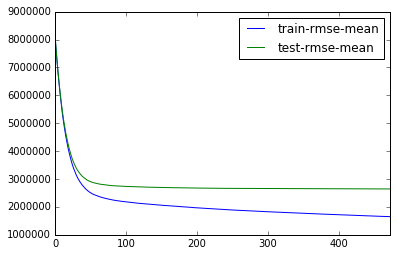

In [58]:
# Uncomment to tune XGB `num_boost_rounds`

cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=20, show_stdv=False)
cv_result[['train-rmse-mean', 'test-rmse-mean']].plot()
num_boost_rounds = len(cv_result)

#num_boost_round = 489

In [60]:
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

In [55]:
def rmsle(prediction,true):

    diff = np.log(prediction + 1) - np.log(np.transpose(true) + 1)
    diff2 = np.square(diff)
    sumdiff = 0
    for x in diff2:
        if np.isnan(x):
            pass
        else:
            sumdiff += x
    rmsle = np.sqrt(sumdiff/len(diff2))
    return rmsle

In [56]:
predicted = model.predict(dtest)
print predicted
print rmsle(y_test,predicted) - 0.14

[ 5295589.  4778608.  9134212. ...,  8764162.  7737655.  5851355.]
0.343896833049


In [17]:
xgb_params = {
    'eta': 0.05,
    #'gamma': 0.03,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
model2 = xgb.Booster(xgb_params) #init model
model2.load_model("first_xgb.model") # load data



In [25]:
y_pred2 = pd.read_csv('submission.csv')
y_pred2.head()

,id,price_doc
0,30474,5255243.5
1,30475,8370524.0
2,30476,5534255.5
3,30477,5774500.0
4,30478,5000616.5


In [26]:
y_pred1 = pd.DataFrame({'id': id_test, 'price_doc': model.predict(dtest)})
y_pred1.head()

,id,price_doc
0,30474,5469203.5
1,30475,8191015.5
2,30476,5353234.0
3,30477,5915246.5
4,30478,5144602.0


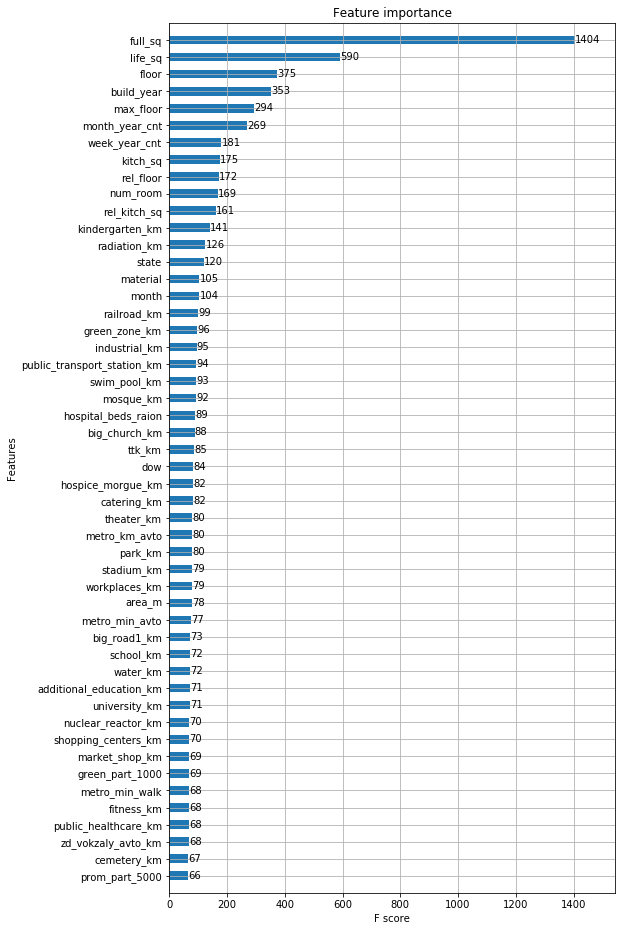

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [68]:
#y_pred = (y_pred1.price_doc + y_pred2.price_doc)/2
y_pred = model.predict(dtest)
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)

In [69]:
from io import BytesIO  
import requests  
import json  
import pandas as pd

def put_file(credentials, local_file_name):  
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage V3."""
    f = open(local_file_name,'r')
    my_data = f.read()
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/', local_file_name])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.put(url=url2, headers=headers2, data = my_data )
    print resp2


In [70]:
# The code was removed by DSX for sharing.

<Response [201]>
